In [13]:
# if you want to run the symantic analysis you'll have to install libraries using nltk.downloader

In [60]:
import glob, os 
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

### Function to download all tweets from single user
Twitter limits us to most recent 3,235 tweets, but this will cover a very interesting time period from last year through the bubble and crash.

Source: https://github.com/suraj-deshmukh/get_tweets/blob/master/tweets-by-daterange.py

In [ ]:
#!/usr/bin/env python
# encoding: utf-8

import tweepy #https://github.com/tweepy/tweepy
import csv

#Twitter API credentials
consumer_key = 'put your key or secret here'
consumer_secret = 'put your key or secret here'
access_key = 'put your key or secret here'
access_secret = 'put your key or secret here'

def get_all_tweets(screen_name):
	
	#authorize twitter, initialize tweepy
	auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
	auth.set_access_token(access_key, access_secret)
	api = tweepy.API(auth)
	
	#initialize a list to hold all the tweepy Tweets
	alltweets = []	
	
	#make initial request for most recent tweets (200 is the maximum allowed count)
	new_tweets = api.user_timeline(screen_name = screen_name,count=200)
	
	#save most recent tweets
	alltweets.extend(new_tweets)
	
	#save the id of the oldest tweet less one
	oldest = alltweets[-1].id - 1
	
	#keep grabbing tweets until there are no tweets left to grab
	while len(new_tweets) > 0:
		print "getting tweets before %s" % (oldest)
		
		#all subsiquent requests use the max_id param to prevent duplicates
		new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)
		
		#save most recent tweets
		alltweets.extend(new_tweets)
		
		#update the id of the oldest tweet less one
		oldest = alltweets[-1].id - 1
		
		print "...%s tweets downloaded so far" % (len(alltweets))
	
	#transform the tweepy tweets into a 2D array that will populate the csv	
	outtweets = [[tweet.id_str, tweet.created_at, tweet.text.encode("utf-8")] for tweet in alltweets]
	
	#write the csv	
	with open('%s_tweets.csv' % screen_name, 'wb') as f:
		writer = csv.writer(f)
		writer.writerow(["id","created_at","text"])
		writer.writerows(outtweets)
	
	pass


### Pandas df of influential voices on cryptocurrency

MarketWatch publishes a list of the 30 most influential tweeters on crypto. As a trial, I downloaded all the tweets I could get from users in the list. It's also possible to get live feeds, but we can use this data for model-buildiing and testing purposes. The next cell gets the tweets from the list in *influencers*.

Source: https://www.marketwatch.com/story/bitcoin-and-cryptocurrency-on-twitter-the-most-important-people-to-follow-2017-12-04

### A partial list of top 30 influencers
Because I imported some by hand first to see how it worked, then made a list to automate the rest.

In [12]:
influencers = ["CharlieShrem", "ljxie", "JihanWu", "starkness", "PerianneDC", "NickSzabo4", "adam3us","WhalePanda", "cburniske", "TuurDemeester", "AriannaSimpson"]

In [ ]:
# puts individiual csv files in the working directory
map(get_all_tweets, influencers)

In [14]:
# concatenates the individual files into a single df
# csv files must be in your working directory
df = pd.concat(map(pd.read_csv, glob.glob("*.csv")))

In [8]:
df.head()

,id,created_at,text
3231,798892330942140417,2016-11-16 14:15:49,"@peterhowitt @Halsrethink ""Will not compete"" b..."
3232,798660128962592768,2016-11-15 22:53:07,@peterhowitt @Halsrethink Remember ISDN? That ...
3233,798633739920162816,2016-11-15 21:08:16,Bitcoin Q&amp;A: Who determines the value of b...
3234,798628995642200066,2016-11-15 20:49:25,"RT @a_hotz: Wir freuen uns wahnsinnig, dass @a..."
3235,798572382554243072,2016-11-15 17:04:27,@BillySangster We'll have to reorganize societ...


In [15]:
# there are 63,378 tweets from these influencers
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 64378 entries, 0 to 3235
Data columns (total 3 columns):
id            64378 non-null int64
created_at    64378 non-null object
text          64378 non-null object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB


### Create a sentiment scale
This will be five catetories, but the sentiment analyzer also gives a numeric score.

In [22]:
# Scale for determing the 5 sentiment categories, each is even width
def scale (score):
    if score <= -.6:
        return "extremely_negative"
    if score <= -.2:
        return "negative"
    if score <= .2:
        return "neutral"
    if score <= .6:
        return "positive"
    if score <= 1:
        return "extremely_positive"

### Sentiment analyzer
We next create the sentiment analyzer object used to find the overall sentiment of each of the tweets. The **score_tweets** function accepts a list of tweets and returns the overall score on the five point scale.

In [19]:
# Creating the sentiment analyzer object
sid = SentimentIntensityAnalyzer()

### Function to score the tweets
Assumes the data is in dataframe 'df' and that variables are named accordingly.

In [23]:
def score_tweets(tweets):
    # Determing the sentiment and sentiment score for each of the tweets.
    sentiment = []
    score = []
    for tweet in tweets:
        ss = sid.polarity_scores(str(tweet))
        sentiment.append(scale(ss['compound']))
        score.append(ss['compound'])
    
    return sentiment, score

sentiment, score = score_tweets(df.text)    

df['sentiment'] = sentiment
df['score'] = score

### See the sentiment category and raw score
Next we have to group and aggregate by day to correspond with our daily price.

In [26]:
df.head()

,id,created_at,text,sentiment,score
0,965368977881886720,2018-02-18 23:34:34,RT @Jensen: That blows. GG Fox!,positive,0.4981
1,965367147990892544,2018-02-18 23:27:18,gg. Tough loss. Fuel for practice https://t....,neutral,-0.1531
2,965349444664180741,2018-02-18 22:16:57,RT @lolesports: Who's the #1 in North America?...,neutral,0.0000
3,965348773323919360,2018-02-18 22:14:17,RT @Cloud9: Today #C9LoL battles @echofoxgg fo...,negative,-0.3818
4,965042976794714112,2018-02-18 01:59:09,@cryptograffiti can you send me a DM so i can ...,neutral,0.0000


### Fix some data types

In [25]:
# convert text to datetime object
df['created_at'] = pd.to_datetime(df['created_at'])

In [46]:
# id and sentiment are categoricals
df['id'] = df['id'].astype('category')
df['sentiment'] = df['sentiment'].astype('category')
df['text'] = df['text'].astype('string')

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64378 entries, 0 to 3235
Data columns (total 5 columns):
id            64378 non-null category
created_at    64378 non-null datetime64[ns]
text          64378 non-null object
sentiment     64378 non-null category
score         64378 non-null float64
dtypes: category(2), datetime64[ns](1), float64(1), object(1)
memory usage: 6.5+ MB


### Make a time series of average daily sentiment

In [53]:
# make a time series of mean score per day
ts = df.groupby(pd.Grouper(key='created_at', freq='D')).mean()

In [54]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2996 entries, 2009-12-08 to 2018-02-19
Freq: D
Data columns (total 1 columns):
score    2371 non-null float64
dtypes: float64(1)
memory usage: 46.8 KB


In [55]:
ts.head()

,score
created_at,
2009-12-08,0.214733
2009-12-09,0.822500
2009-12-10,-0.743000
2009-12-11,NaN
2009-12-12,NaN


In [74]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

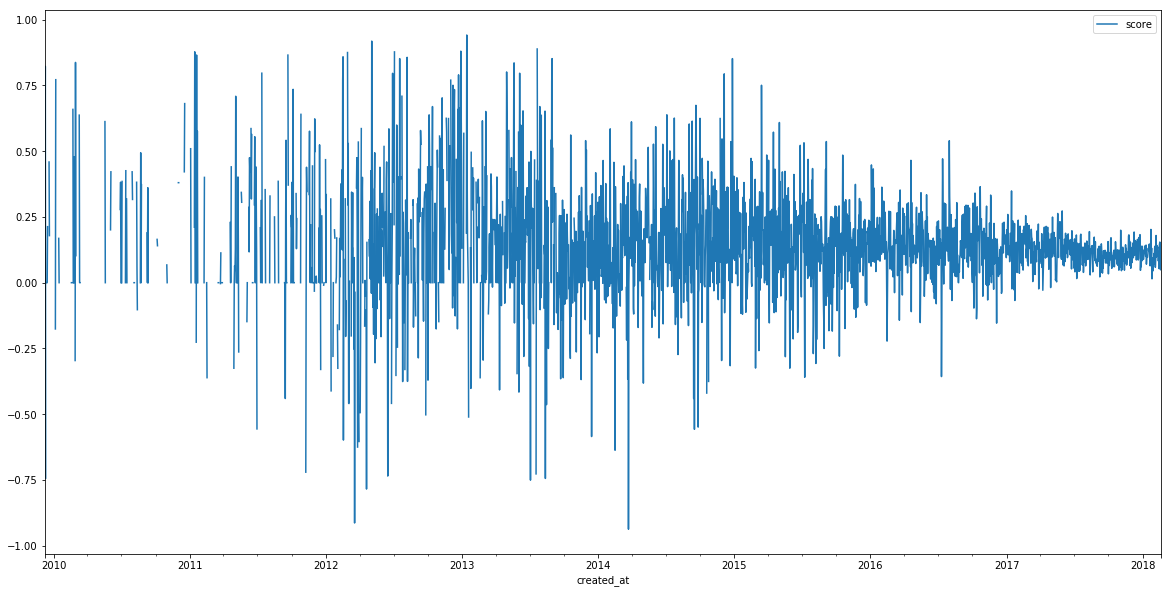

In [75]:
ts.resample('D').sum().plot()

In [76]:
df.to_csv("crypto_sent.csv")